In [4]:
import pathlib
from pprint import pprint
from matplotlib import pyplot as plt
import numpy as np
from lips.benchmark.powergridBenchmark import PowerGridBenchmark
from lips.utils import get_path

In [2]:
# indicate required paths
LIPS_PATH = pathlib.Path().resolve().parent.parent.parent # it is supposed that the notebook had run from getting_started folder
DATA_PATH = LIPS_PATH / "reference_data" / "powergrid" / "l2rpn_case14_sandbox" / "DC"
BENCH_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "benchmarks" / "l2rpn_case14_sandbox.ini"
SIM_CONFIG_PATH = LIPS_PATH / "configurations" / "powergrid" / "simulators"
BASELINES_PATH = LIPS_PATH / "trained_baselines" / "powergrid"
TRAINED_MODEL_PATH = LIPS_PATH / "trained_models" / "powergrid"
EVALUATION_PATH = LIPS_PATH / "evaluation_results" / "PowerGrid"
LOG_PATH = LIPS_PATH / "lips_logs.log"

In [3]:
benchmark4 = PowerGridBenchmark(benchmark_name="Benchmark4",
                                benchmark_path=DATA_PATH,
                                load_data_set=True,
                                log_path=LOG_PATH,
                                config_path=BENCH_CONFIG_PATH,
                               )

In [ ]:
benchmark4.config.get_option("eval_dict")

In [13]:
from lips.augmented_simulators.torch_models.gnn import TorchGCN
from lips.augmented_simulators.torch_simulator import TorchSimulator
#from lips.dataset.scaler import StandardScaler

In [14]:
torch_sim = TorchSimulator(name="torch_gcn",
                           model=TorchGCN,
                           scaler=None,
                           log_path=LOG_PATH,
                           device="cuda:0", # use "cpu" if you don't have a GPU available on your machine
                           seed=42,
                           bench_config_path=BENCH_CONFIG_PATH,
                           bench_config_name="Benchmark4",
                           sim_config_path=SIM_CONFIG_PATH / "torch_gnn.ini",
                           sim_config_name="GCN_CONFIG_RECOMMENDED_1" # use the default set of hyper parameters
                          )

In [ ]:
torch_sim.params

### Train the augmented simulator

In [ ]:
torch_sim.train(benchmark4.train_dataset, benchmark4.val_dataset, save_path=None, epochs=10, train_batch_size=128)

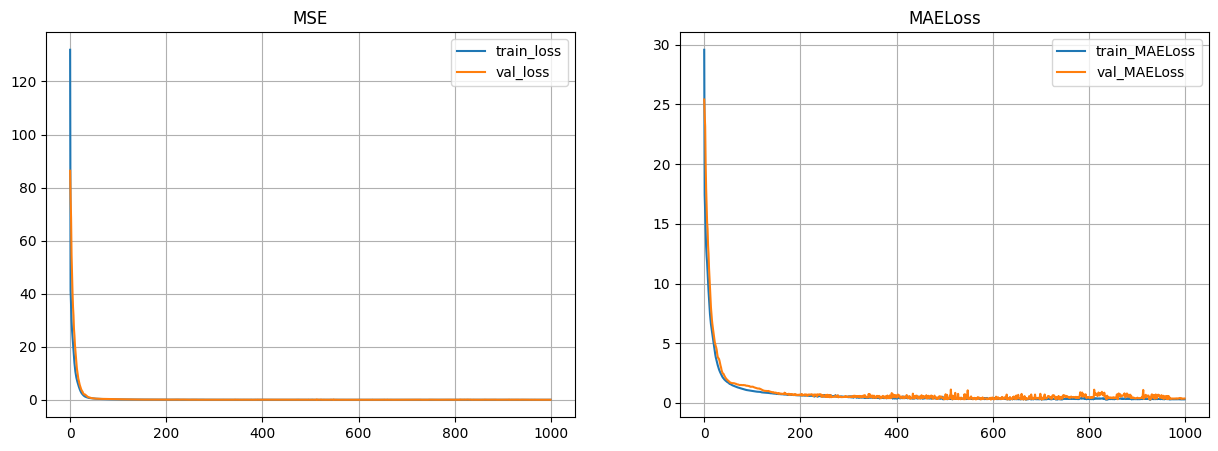

In [10]:
torch_sim.visualize_convergence()

### Save the trained model

In [11]:
SAVE_PATH = get_path(TRAINED_MODEL_PATH, benchmark4)
torch_sim.save(SAVE_PATH)

In [19]:
state_before_load = torch_sim._model.state_dict()

### Load the trained model

In [9]:
from lips.augmented_simulators.torch_models.gnn import TorchGCN
from lips.augmented_simulators.torch_simulator import TorchSimulator

torch_sim = TorchSimulator(name="torch_gcn",
                           model=TorchGCN,
                           scaler=None,
                           log_path=LOG_PATH,
                           device="cuda:0", # use "cpu" if you don't have a GPU available on your machine
                           seed=42,
                           bench_config_path=BENCH_CONFIG_PATH,
                           bench_config_name="Benchmark4",
                           sim_config_path=SIM_CONFIG_PATH / "torch_gnn.ini",
                           sim_config_name="GCN_CONFIG_RECOMMENDED_1", # use the default set of hyper parameters
                           #attr_y=("theta_or", "theta_ex")
                          )

In [10]:
LOAD_PATH = get_path(TRAINED_MODEL_PATH, benchmark4)
torch_sim.restore(path=LOAD_PATH)

In [23]:
state_after_load = torch_sim._model.state_dict()

In [ ]:
for key in state_before_load.keys():
    print(key)
    assert torch.all(state_before_load.get(key) == state_after_load.get(key))

### Predict using the trained augmented simulator

In [11]:
metrics = benchmark4.evaluate_simulator(dataset="test", augmented_simulator=torch_sim, save_path=None, save_predictions=False)

processing the dataset:  test
processing the dataset:  test


In [7]:
metrics

{'test': {'ML': {'MSE_avg': {'theta_or': 0.000920760678127408,
    'theta_ex': 0.0009734223131090403,
    'p_or': 0.12837053835391998,
    'p_ex': 0.12837053835391998},
   'MAE_avg': {'theta_or': 0.02128021977841854,
    'theta_ex': 0.022577201947569847,
    'p_or': 0.25821977853775024,
    'p_ex': 0.25821977853775024},
   'MAPE_avg': {'theta_or': 567091396608.0,
    'theta_ex': 0.0036648546811193228,
    'p_or': 45471456296960.0,
    'p_ex': 45471456296960.0},
   'MAPE_90_avg': {'theta_or': nan,
    'theta_ex': 0.0030192140354167634,
    'p_or': 0.015663714870824436,
    'p_ex': 0.015663714870824436},
   'TIME_INF': 14.771648640278727},
  'Physics': {'LOSS_POS': {}},
  'IndRed': {'TIME_INF': 15.331753679085523}}}